# Intro

This is a notebook summarizing experiments run in Summer 2024 by Nick Huang investigating the various use cases and performance of Prediction Powered Inference (PPI).

The equation for PPI variance, which is a key focus is given by 
\begin{equation}
    \sqrt{\frac{\hat{\sigma}^2_{f - Y}}{n} + \frac{\hat{\sigma}^2_{f}}{N}} 
\end{equation}

Recall that the variance of the classical estimator is given by

\begin{equation}
    \sqrt{\frac{\hat{\sigma}^2_{Y}}{n}}
\end{equation}

## Experiment 1

The point of experiment 1 is to be a baseline experiment of when PPI performs well. We have 3 distributions: the training distribution, the labelled (gold) distribution, and the unlabelled (ppi) distribution. In this experiment, we set all 3 distributions to be the same, and we also observe what happens when the data becomes noisier and noisier. As well, we compare what happens when we use a good/bad model, and how PPI performs compared to just classical confidence interval generation.

For this experiment, we will be performing mean estimation.

### Setting 1

Here we have a very idealized experiment, $X \sim Gamma(2, 2)$, and $Y = 4X + \varepsilon$. Here $\varepsilon \sim N(0, m^2 * \alpha * \beta * \frac{1 - \rho}{\rho})$, in this case, $m = 4, \alpha = 2, \beta = 2$, and $\rho$ is varied so that $Corr(X, Y) = \rho$.

We fit a linear regression model, in this scenario we expect PPI to permform very well, and should be a big improvement over classical methods.

In the following example, we set $n = 128, 16, N = 10000$, in which case, the second term in $(1)$ is irrelevant. (specify here that n = labelled data, N = unlabelled data).

We run each experiment 1000 times, resampling every population (training, labelled, unlabelled) every time.

Add in $n = 16, 128, 512, 1024$

- In bullet points
- Exact experiment settings

- Data generation (Lin/nolin, noise etc)
- Model (Lin/Nonlin)
- Sample size
- Correlation (for lin)
- Independent variable basically
- Distribution shift
- Technique
- Clip

### Setting 1 Configurations

- Gold (Labelled) Distribution $\sim Gamma(2, 2)$, linear transformation, sample size $n = 16, 128, 512, 1024$
- Unlabelled distribution $\sim Gamma(2, 2)$, linear transformation, sample size $N = 10000$
- $Corr(X, Y) = \rho = 0.3, 0.5, 0.7, 0.9$
- No distribution shift
- Linear regression

* Note for the trest of the experiments, $Gamma(\alpha, \beta)$ represents scale, scale. That is, $E[X] = \alpha \beta, Var[X] = \alpha \beta^2$

In [1]:
# Imports

import distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import ppi
import ppi_py
import scipy.stats as stats
import pandas as pd
import ml_models as ml
import distributions as dist

import yaml
import os
import sys
import argparse
import plotting
import copy

c:\Users\Ziyu\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


As an example, we will show what happens when $\rho = 0.75$, and fit a linear regression model to see how well the model performs. 

In [14]:
# Load file

config = "../configs/Experiment_1_new/128g_l_reg.yaml"
with open(config, 'r') as stream:
    config = yaml.safe_load(stream)

def test(config):
    rho_vals = [.75]
    pop_config = config['experiment']['parameters']['gold_population']
    for rho in rho_vals:
        pop_config['y_population']['rho'] = rho
        x_gold, y_gold = dist.sample_population(pop_config)

        # plot the x population and the y population
        fig, ax = plt.subplots(2)
        ax[0].hist(x_gold, bins=50)
        ax[0].set_title("X Population")
        ax[1].scatter(x_gold, y_gold, alpha=0.5, s=15)
        ax[1].set_title("Y Population")
        plt.show()

        ml_config = config['experiment']['model']

        train_config = copy.deepcopy(pop_config)
        train_config['x_population']['size'] = 10000

        x_train, y_train = dist.sample_population(train_config)

        model = ml.train_model(x_train, y_train, ml_config)

        y_gold_fitted = model.predict(x_gold)

        # plot the gold population and the fitted gold population

        plt.scatter(x_gold, y_gold, alpha=0.5, s=15, label="True Gold Population")
        plt.scatter(x_gold, y_gold_fitted, alpha=0.5, s=15, label="Fitted Gold Population")
        plt.title("Gold Population with Fitted Gold Population")
        plt.legend()
        plt.show()
        
    
    return 

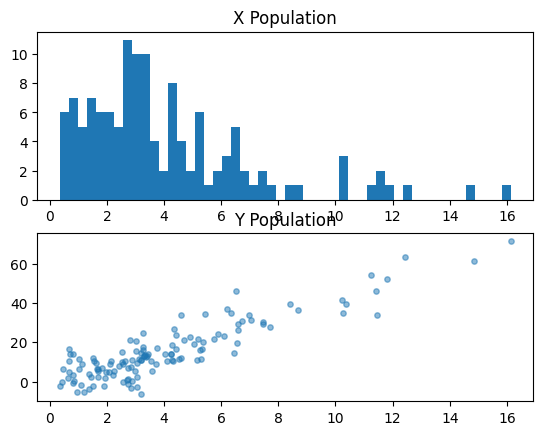

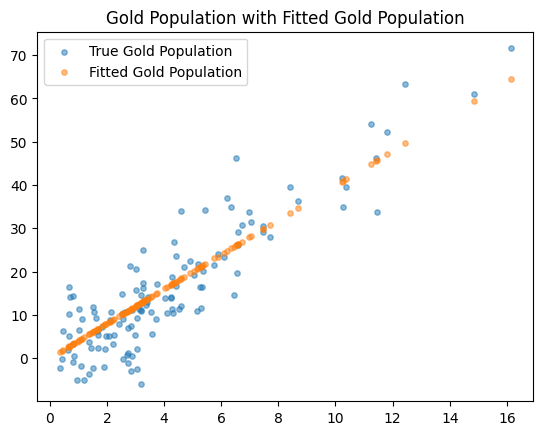

In [15]:
# Visualize

test(config)

As we can see, the model fits reasonably well. The following is a graph that shows the Widths generated by various other methods.

Band represents middle 60% of the results.

In [4]:
# Display the wdiths vs rho plot

# Set the variable to the path of the PNG file
gold_128 = '../experiments/Experiment_1_new/128g_l_reg_2024-08-13-23-12-39/plots/widthsplotwithratio.png'
gold_16 = '../experiments/Experiment_1_new/16g_l_reg_2024-08-13-23-12-17/plots/widthsplotwithratio.png'
gold_128_ri = '../experiments/Experiment_1_new/128g_l_reg_2024-08-13-23-12-39/plots/relativeimprovementwithratio.png'
gold_16_ri = '../experiments/Experiment_1_new/16g_l_reg_2024-08-13-23-12-17/plots/relativeimprovementwithratio.png'

# Display the PNG file
img_128 = plt.imread(gold_128)
img_16 = plt.imread(gold_16)
im_128_ri = plt.imread(gold_128_ri)
im_16_ri = plt.imread(gold_16_ri)

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img_128)
ax[0, 0].axis('off')
ax[0, 0].set_title('Gold Pop: 128')
ax[0, 1].imshow(img_16)
ax[0, 1].axis('off')
ax[0, 1].set_title('Gold Pop: 16')
ax[1, 0].imshow(im_128_ri)
ax[1, 0].axis('off')
ax[1, 0].set_title('Gold Pop: 128')
ax[1, 1].imshow(im_16_ri)
ax[1, 1].axis('off')
ax[1, 1].set_title('Gold Pop: 16')

# remove the whitespace between the plots
plt.subplots_adjust(wspace=0, hspace=0.1)

# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../experiments/Experiment_1_new/128g_l_reg_2024-08-13-23-12-39/plots/widthsplotwithratio.png'

In this idealized scenario, it is clear that PPI provides a very large performance boost, and the performance boost gets much greater as the model becomes a better fit. No surprises here.

If you look carefully, "Naive Widths" performs very well, which refers to imputing the values and treating those values as true data, then constructing a confidence interval as usual.

In [ ]:
# Coverage plots

# Set the variable to the path of the PNG file
gold_128_cov = '../experiments/Experiment_1/reg_lin_128_2024-07-30-00-07-14/plots/coverageplot.png'
gold_16_cov = '../experiments/Experiment_1/reg_lin_16_2024-07-30-00-06-38/plots/coverageplot.png'

# Display the PNG file
img_128_cov = plt.imread(gold_128_cov)
img_16_cov = plt.imread(gold_16_cov)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_128_cov)
ax[0].axis('off')
ax[0].set_title('Gold Pop: 128')
ax[1].imshow(img_16_cov)
ax[1].axis('off')
ax[1].set_title('Gold Pop: 16')
# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../experiments/Experiment_1/reg_lin_128_2024-07-30-00-07-14/plots/coverageplot.png'

Unsurprisingly, since imputation gives biased results if the ML model is biased at all, and this method does not follow correct statistical assumptions, the confidence intervals generated, while small, don't often cover the true value.

In [ ]:
# Create a table of the average results of this experiment

# Load the results

results_16 = pd.read_csv('../experiments/Experiment_1_new/16g_l_reg_2024-08-13-23-12-17/results/results.csv')
results_128 = pd.read_csv('../experiments/Experiment_1_new/128g_l_reg_2024-08-13-23-12-39/results/results.csv')
results_512 = pd.read_csv('../experiments/Experiment_1_new/512g_l_reg_2024-08-14-23-50-59/results/results.csv')
results_1024 = pd.read_csv('../experiments/Experiment_1_new/1024g_l_reg_2024-08-14-23-54-03/results/results.csv')

# Create a table of the average results


techniques = results_16['technique'].unique()
important_columns = ['ci_width', 'empirical_coverage', 'relative_improvement']

for technique in techniques:
    technique_df_setting_1_reg = pd.DataFrame()
    print(f"Technique: {technique}")
    for column in important_columns:
        #print(f"{column}:")
        #print(f"Gold size 16: {results_16[results_16['technique'] == technique][column].mean()}")
        gold_16_mean = results_16[results_16['technique'] == technique][column].mean()
        #print(f"Gold size 128: {results_128[results_128['technique'] == technique][column].mean()}")
        gold_128_mean = results_128[results_128['technique'] == technique][column].mean()
        #print(f"Gold size 512: {results_512[results_512['technique'] == technique][column].mean()}")
        gold_512_mean = results_512[results_512['technique'] == technique][column].mean()
        #print(f"Gold size 1024: {results_1024[results_1024['technique'] == technique][column].mean()}")
        gold_1024_mean = results_1024[results_1024['technique'] == technique][column].mean()
        technique_df_setting_1_reg[column] = [gold_16_mean, gold_128_mean, gold_512_mean, gold_1024_mean]
        gold_pops = [16, 128, 512, 1024]
        technique_df_setting_1_reg['Gold Population Size'] = gold_pops
        #print("\n")

    print(technique_df_setting_1_reg)
    # save to markdown format
    technique_df_setting_1_reg.to_markdown()
    print(technique_df_setting_1_reg.to_markdown())

Technique: classical
    ci_width  Gold Population Size  empirical_coverage  relative_improvement
0  16.083472                    16             0.94800                   0.0
1   5.383841                   128             0.94850                   0.0
2   2.675773                   512             0.95425                   0.0
3   1.889011                  1024             0.95200                   0.0
|    |   ci_width |   Gold Population Size |   empirical_coverage |   relative_improvement |
|---:|-----------:|-----------------------:|---------------------:|-----------------------:|
|  0 |   16.0835  |                     16 |              0.948   |                      0 |
|  1 |    5.38384 |                    128 |              0.9485  |                      0 |
|  2 |    2.67577 |                    512 |              0.95425 |                      0 |
|  3 |    1.88901 |                   1024 |              0.952   |                      0 |
Technique: ppi
   ci_width  Gold Pop

### Setting 2

In this case, we change the distribution of $X \sim N(0, 4^2)$, however in this case, we set $Y = 3 * \sin (X) + \exp(X / 6) + \varepsilon$. Here $\varepsilon \sim N(0, (3 * \eta)^2)$. As such, the relationship is non symmetric, and highly non-linear. $
\eta = 0.3, 0.5, 0.7, 0.9$

### Setting 2 Configurations

- Gold (Labelled) Distribution $\sim N(0, 4^2)$, non-linear transformation, sample size $n = 16, 128, 512, 1024$
- Unlabelled distribution $\sim N(0, 4^2)$, non-linear transformation, sample size $N = 10000$
- $\eta = 0.1, 0.3, 0.5, 0.7, 0.9$, prevalence of noise
- No distribution shift
- Linear regression/XGBoost

In the example $\eta = 0.4$

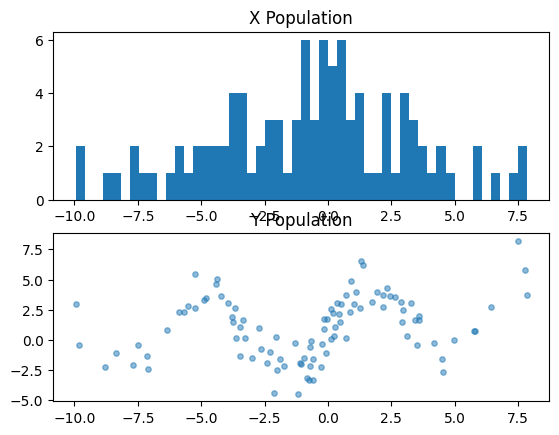

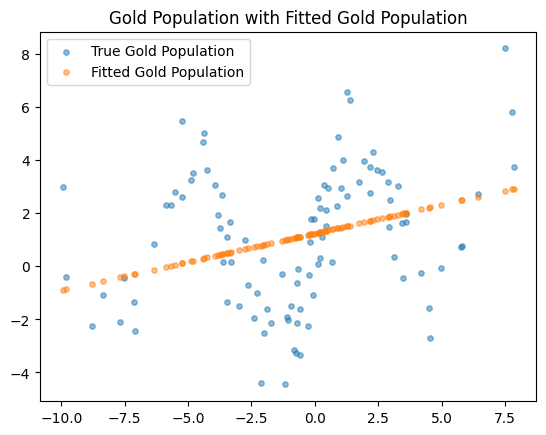

In [17]:
# Visualize setting 2

config2 = "../configs/Experiment_1_new/128g_nl_reg.yaml"
with open(config2, 'r') as stream:
    config2 = yaml.safe_load(stream)

def test2(config):
    rho_vals = [.4]
    pop_config = config['experiment']['parameters']['gold_population']
    for rho in rho_vals:
        pop_config['y_population']['rho'] = rho
        pop_config['x_population']['size'] = 100
        x_gold, y_gold = dist.sample_population(pop_config)

        # plot the x population and the y population
        fig, ax = plt.subplots(2)
        ax[0].hist(x_gold, bins=50)
        ax[0].set_title("X Population")
        ax[1].scatter(x_gold, y_gold, alpha=0.5, s=15)
        ax[1].set_title("Y Population")
        plt.show()

        ml_config = config['experiment']['model']

        train_config = copy.deepcopy(pop_config)
        train_config['x_population']['size'] = 10000

        x_train, y_train = dist.sample_population(train_config)

        model = ml.train_model(x_train, y_train, ml_config)

        y_gold_fitted = model.predict(x_gold)

        # plot the gold population and the fitted gold population


        plt.scatter(x_gold, y_gold, alpha=0.5, s=15, label="True Gold Population")
        plt.scatter(x_gold, y_gold_fitted, alpha=0.5, s=15, label="Fitted Gold Population")
        plt.title("Gold Population with Fitted Gold Population")
        plt.legend()
        plt.show()
    

    return 

test2(config2)

As we can see here, we do not expect PPI to have much benefit over classical methods.

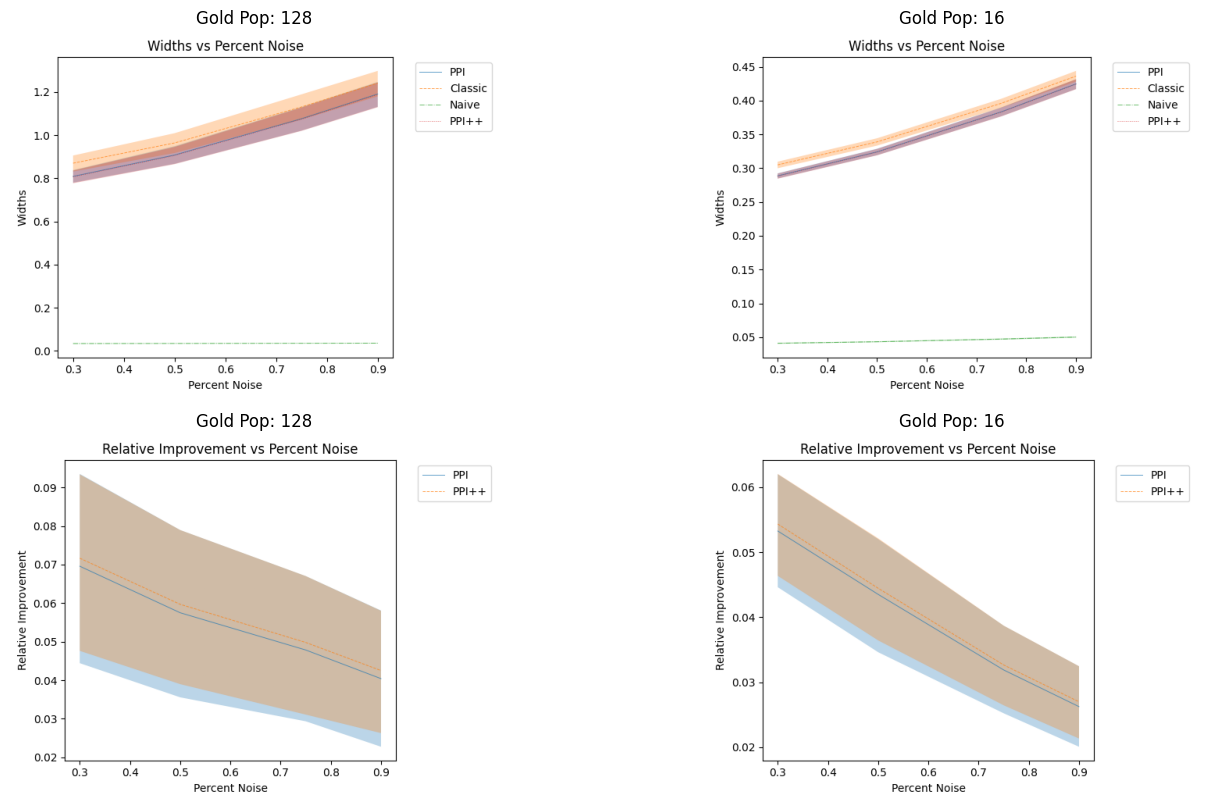

In [ ]:
# Display the wdiths vs rho plot

# Set the variable to the path of the PNG file
gold_16_nl = '../experiments/Experiment_1_new/16g_nl_reg_2024-08-14-23-50-37/plots/widthsplot.png'
gold_128_nl = '../experiments/Experiment_1_new/128g_nl_reg_2024-08-13-23-13-23/plots/widthsplot.png'
gold_16_nl_ri = '../experiments/Experiment_1_new/16g_nl_reg_2024-08-14-23-50-37/plots/relativeimprovement.png'
gold_128_nl_ri = '../experiments/Experiment_1_new/128g_nl_reg_2024-08-13-23-13-23/plots/relativeimprovement.png'

# Display the PNG file
img_128_nl = plt.imread(gold_128_nl)
img_16_nl = plt.imread(gold_16_nl)
im_128_nl_ri = plt.imread(gold_128_nl_ri)
im_16_nl_ri = plt.imread(gold_16_nl_ri)
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img_128_nl)
ax[0, 0].axis('off')
ax[0, 0].set_title('Gold Pop: 128')
ax[0, 1].imshow(img_16_nl)
ax[0, 1].axis('off')
ax[0, 1].set_title('Gold Pop: 16')
ax[1, 0].imshow(im_128_nl_ri)
ax[1, 0].axis('off')
ax[1, 0].set_title('Gold Pop: 128')
ax[1, 1].imshow(im_16_nl_ri)
ax[1, 1].axis('off')
ax[1, 1].set_title('Gold Pop: 16')

# remove the whitespace between the plots
plt.subplots_adjust(wspace=0, hspace=0.1)

# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()


No surprises here, PPI provides little to no benefit. We can also see what happens to how often imputation covers the true value is a very poorly fitted model. A somewhat surprising result is that having a higher gold population causes even more bias into the model.

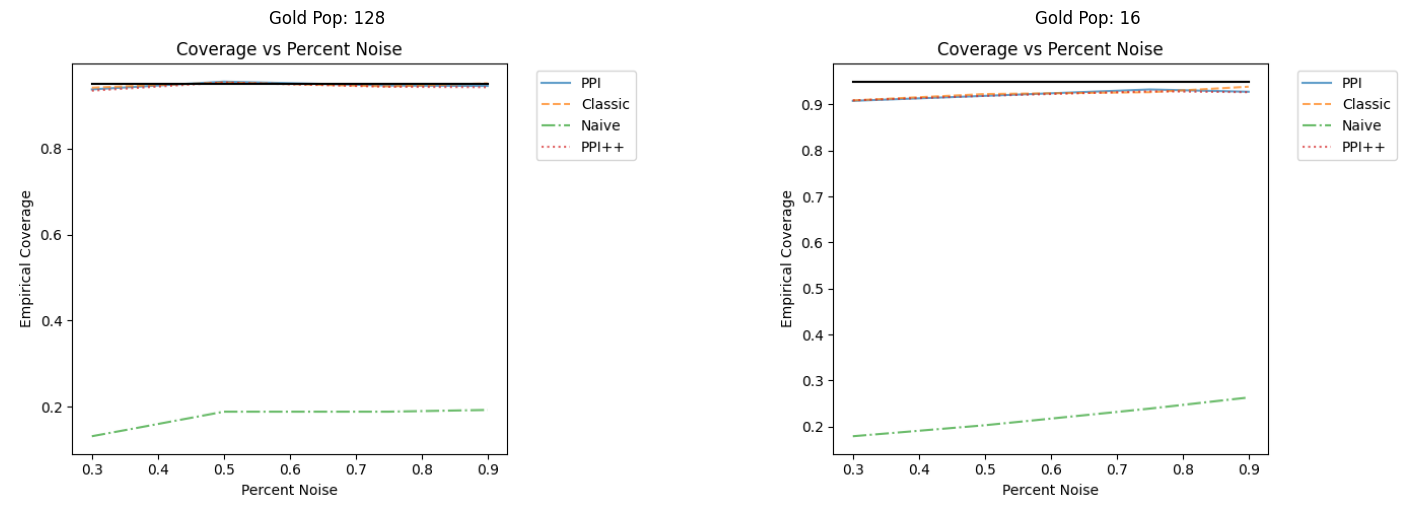

In [ ]:
# Coverage plots, setting 2

# Set the variable to the path of the PNG file
gold_128_cov_nl = '../experiments/Experiment_1_new/128g_nl_reg_2024-08-13-23-13-23/plots/coverageplot.png'
gold_16_cov_nl = '../experiments/Experiment_1_new/16g_nl_reg_2024-08-14-23-50-37/plots/coverageplot.png'

# Display the PNG file
img_128_cov_nl = plt.imread(gold_128_cov_nl)
img_16_cov_nl = plt.imread(gold_16_cov_nl)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_128_cov_nl)
ax[0].axis('off')
ax[0].set_title('Gold Pop: 128')
ax[1].imshow(img_16_cov_nl)
ax[1].axis('off')
ax[1].set_title('Gold Pop: 16')
# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()

In [ ]:
# Create a table of the average results of this experiment

# Load the results

results_16 = pd.read_csv('../experiments/Experiment_1_new/16g_nl_reg_2024-08-14-23-50-37/results/results.csv')
results_128 = pd.read_csv('../experiments/Experiment_1_new/128g_nl_reg_2024-08-13-23-13-23/results/results.csv')
results_512 = pd.read_csv('../experiments/Experiment_1_new/512g_nl_reg_2024-08-14-23-51-21/results/results.csv')
results_1024 = pd.read_csv('../experiments/Experiment_1_new/1024g_nl_reg_2024-08-14-23-54-25/results/results.csv')

# Create a table of the average results


techniques = results_16['technique'].unique()
important_columns = ['ci_width', 'empirical_coverage', 'relative_improvement']

for technique in techniques:
    technique_df_setting_2_reg = pd.DataFrame()
    print(f"Technique: {technique}")
    for column in important_columns:
        #print(f"{column}:")
        #print(f"Gold size 16: {results_16[results_16['technique'] == technique][column].mean()}")
        gold_16_mean = results_16[results_16['technique'] == technique][column].mean()
        #print(f"Gold size 128: {results_128[results_128['technique'] == technique][column].mean()}")
        gold_128_mean = results_128[results_128['technique'] == technique][column].mean()
        #print(f"Gold size 512: {results_512[results_512['technique'] == technique][column].mean()}")
        gold_512_mean = results_512[results_512['technique'] == technique][column].mean()
        #print(f"Gold size 1024: {results_1024[results_1024['technique'] == technique][column].mean()}")
        gold_1024_mean = results_1024[results_1024['technique'] == technique][column].mean()
        technique_df_setting_2_reg[column] = [gold_16_mean, gold_128_mean, gold_512_mean, gold_1024_mean]
        #print("\n")
    print(technique_df_setting_2_reg)

Technique: classical
   ci_width  empirical_coverage  relative_improvement
0  0.368971             0.92450                   0.0
1  1.051712             0.94725                   0.0
2  0.522177             0.93725                   0.0
3  0.368971             0.92450                   0.0
Technique: ppi
   ci_width  empirical_coverage  relative_improvement
0  0.355182             0.92200              0.038727
1  0.996148             0.94575              0.053826
2  0.500664             0.93950              0.042569
3  0.355182             0.92200              0.038727
Technique: naive
   ci_width  empirical_coverage  relative_improvement
0  0.045452             0.22100              0.875764
1  0.034989             0.17575              0.966094
2  0.040325             0.20000              0.921832
3  0.045452             0.22100              0.875764
Technique: ppi_pp
   ci_width  empirical_coverage  relative_improvement
0  0.354867             0.92100              0.039609
1  0.994057

Naturally then, one might one to replace our poorly fitted linear regression model, with another better function appoximator. In this case, we will use XGBoost. 

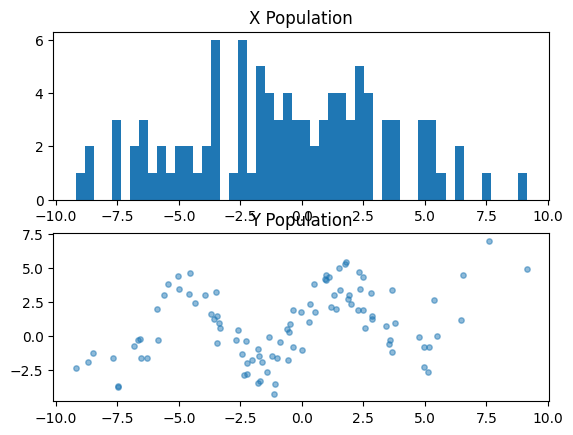

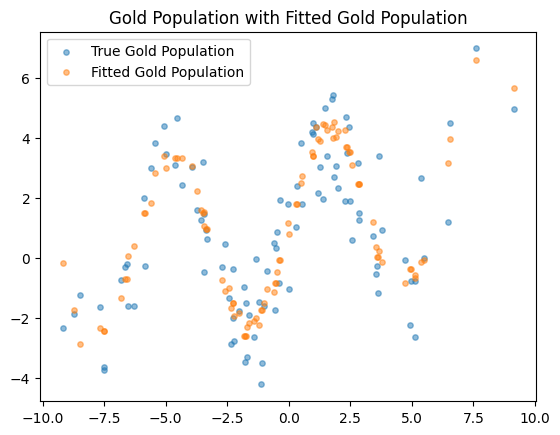

In [18]:
config3 = "../configs/Experiment_1_new/128g_nl_xgb.yaml"
with open(config3, 'r') as stream:
    config3 = yaml.safe_load(stream)

test2(config3)

From our visualization, XGBoost fits the data quite well. We would then expect PPI to perform well and give a significant reduction in width size.

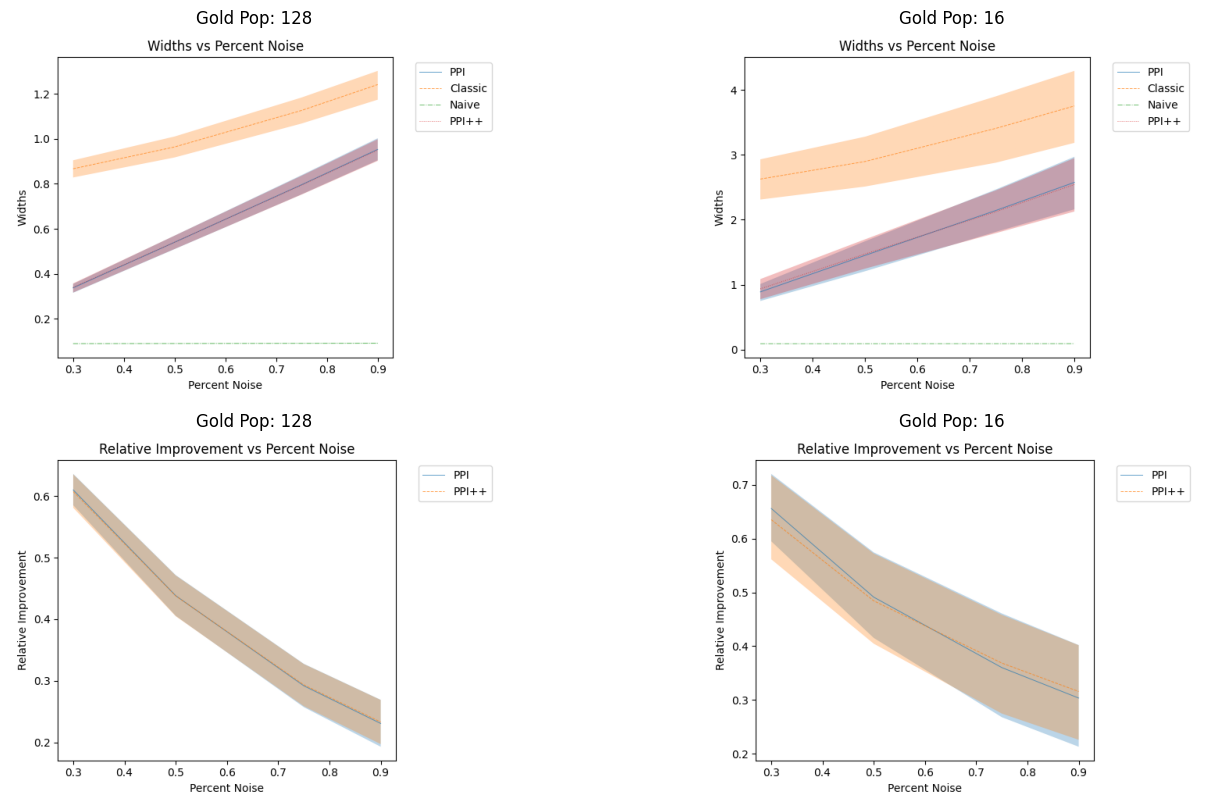

In [ ]:
# Display the wdiths vs rho plot

# Set the variable to the path of the PNG file
gold_16_nl_xgb = '../experiments/Experiment_1_new/16g_nl_xgb_2024-08-13-21-02-12/plots/widthsplot.png'
gold_128_nl_xgb = '../experiments/Experiment_1_new/128g_nl_xgb_2024-08-13-21-21-16/plots/widthsplot.png'
gold_16_nl_ri_xgb = '../experiments/Experiment_1_new/16g_nl_xgb_2024-08-13-21-02-12/plots/relativeimprovement.png'
gold_128_nl_ri_xgb = '../experiments/Experiment_1_new/128g_nl_xgb_2024-08-13-21-21-16/plots/relativeimprovement.png'

# Display the PNG file
img_128_nl_xgb = plt.imread(gold_128_nl_xgb)
img_16_nl_xgb = plt.imread(gold_16_nl_xgb)
im_128_nl_ri_xgb = plt.imread(gold_128_nl_ri_xgb)
im_16_nl_ri_xgb = plt.imread(gold_16_nl_ri_xgb)

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img_128_nl_xgb)
ax[0, 0].axis('off')
ax[0, 0].set_title('Gold Pop: 128')
ax[0, 1].imshow(img_16_nl_xgb)
ax[0, 1].axis('off')
ax[0, 1].set_title('Gold Pop: 16')
ax[1, 0].imshow(im_128_nl_ri_xgb)
ax[1, 0].axis('off')
ax[1, 0].set_title('Gold Pop: 128')
ax[1, 1].imshow(im_16_nl_ri_xgb)
ax[1, 1].axis('off')
ax[1, 1].set_title('Gold Pop: 16')

# remove the whitespace between the plots
plt.subplots_adjust(wspace=0, hspace=0.1)

# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()

Now that the model properly fits the data, we can see that we have good improvements over the classical method again.

In [ ]:
# Create a table of the average results of this experiment

# Load the results

results_16 = pd.read_csv('../experiments/Experiment_1_new/16g_nl_xgb_2024-08-13-21-02-12/results/results.csv')
results_128 = pd.read_csv('../experiments/Experiment_1_new/128g_nl_xgb_2024-08-13-21-21-16/results/results.csv')
results_512 = pd.read_csv('../experiments/Experiment_1_new/512g_nl_xgb_2024-08-14-23-51-43/results/results.csv')
results_1024 = pd.read_csv('../experiments/Experiment_1_new/1024g_nl_xgb_2024-08-14-23-54-48/results/results.csv')

# Create a table of the average results


techniques = results_16['technique'].unique()
important_columns = ['ci_width', 'empirical_coverage', 'relative_improvement']

for technique in techniques:
    technique_df_setting_2_xgb = pd.DataFrame()
    print(f"Technique: {technique}")
    for column in important_columns:
        #print(f"{column}:")
        #print(f"Gold size 16: {results_16[results_16['technique'] == technique][column].mean()}")
        gold_16_mean = results_16[results_16['technique'] == technique][column].mean()
        #print(f"Gold size 128: {results_128[results_128['technique'] == technique][column].mean()}")
        gold_128_mean = results_128[results_128['technique'] == technique][column].mean()
        #print(f"Gold size 512: {results_512[results_512['technique'] == technique][column].mean()}")
        gold_512_mean = results_512[results_512['technique'] == technique][column].mean()
        #print(f"Gold size 1024: {results_1024[results_1024['technique'] == technique][column].mean()}")
        gold_1024_mean = results_1024[results_1024['technique'] == technique][column].mean()
        technique_df_setting_2_xgb[column] = [gold_16_mean, gold_128_mean, gold_512_mean, gold_1024_mean]
        #print("\n")
    technique_df_setting_2_xgb.index = [16, 128, 512, 1024]
    print(technique_df_setting_2_xgb)

Technique: classical
      ci_width  empirical_coverage  relative_improvement
16    3.171755             0.95100                   0.0
128   1.049153             0.94550                   0.0
512   0.522407             0.93425                   0.0
1024  0.369163             0.91725                   0.0
Technique: ppi
      ci_width  empirical_coverage  relative_improvement
16    1.765219             0.92200              0.452764
128   0.656650             0.93250              0.392724
512   0.340399             0.90700              0.366313
1024  0.250757             0.87525              0.337081
Technique: naive
      ci_width  empirical_coverage  relative_improvement
16    0.091044             0.51125              0.969896
128   0.090884             0.51125              0.911506
512   0.090228             0.41225              0.824119
1024  0.090094             0.47750              0.752073
Technique: ppi_pp
      ci_width  empirical_coverage  relative_improvement
16    1.769299   

### Experiment 1 Summary

All in all, this is a baseline experiment to show how PPI performs in various scenarios. Here are the key points:

- PPI performs well, when the model is fit well, with sufficient unlabelled dataset
- PPI gets less benefit as the labelled population size increases, but in general, is still better than classical methods
- PPI has minimal performance gain when the model is bad, but a somewhat reasonable fit
- As data is less varied, and the mean is more clear, we tend to see less improvement

#### Setting 1
Classical Results
|    |   ci_width |   Gold Population Size |   empirical_coverage |   relative_improvement |
|---:|-----------:|-----------------------:|---------------------:|-----------------------:|
|  0 |   16.0835  |                     16 |              0.948   |                      0 |
|  1 |    5.38384 |                    128 |              0.9485  |                      0 |
|  2 |    2.67577 |                    512 |              0.95425 |                      0 |
|  3 |    1.88901 |                   1024 |              0.952   |                      0 | 

PPI Results
|    |   ci_width |   Gold Population Size |   empirical_coverage |   relative_improvement |
|---:|-----------:|-----------------------:|---------------------:|-----------------------:|
|  0 |    9.04658 |                     16 |              0.91925 |               0.45729  |
|  1 |    3.38713 |                    128 |              0.94825 |               0.407842 |
|  2 |    1.76038 |                    512 |              0.95125 |               0.378127 |
|  3 |    1.29217 |                   1024 |              0.949   |               0.348734 |

Naive Results

|    |   ci_width |   Gold Population Size |   empirical_coverage |   relative_improvement |
|---:|-----------:|-----------------------:|---------------------:|-----------------------:|
|  0 |   0.443563 |                     16 |              0.8265  |               0.969453 |
|  1 |   0.44334  |                    128 |              0.829   |               0.913454 |
|  2 |   0.442251 |                    512 |              0.84375 |               0.827613 |
|  3 |   0.440027 |                   1024 |              0.8495  |               0.758118 |

PPI++ Results
|    |   ci_width |   Gold Population Size |   empirical_coverage |   relative_improvement |
|---:|-----------:|-----------------------:|---------------------:|-----------------------:|
|  0 |    9.31634 |                     16 |              0.897   |               0.431307 |
|  1 |    3.41501 |                    128 |              0.94325 |               0.400912 |
|  2 |    1.76111 |                    512 |              0.9495  |               0.377653 |
|  3 |    1.28536 |                   1024 |              0.947   |               0.35278  |

Ratio Estimator Results
|    |   ci_width |   Gold Population Size |   empirical_coverage |   relative_improvement |
|---:|-----------:|-----------------------:|---------------------:|-----------------------:|
|  0 |   10.5793  |                     16 |              0.96275 |               0.354996 |
|  1 |    3.38829 |                    128 |              0.94625 |               0.408048 |
|  2 |    1.64874 |                    512 |              0.9245  |               0.422965 |
|  3 |    1.13083 |                   1024 |              0.89125 |               0.439807 |




## Experiment 2

In this experiment, we will investigate what happens when we apply the problem of distributional shift to the problem. Recall in the previous experiment, the distribution of the training, gold, unlabelled data are all the same. In this case we take $P_X^t \neq P_X^g = P_X^u$, however, in all three distributions, we keep the same probability distribution $P_{Y|X}$. That is, for any point $x$ that is near the training distribution, we expect good inference results. 

On the other hand, if we have a complicated relationship, that is difficult to infer accurately on, we expect as the distribution shifts further and further away from the training data, performance will become worse and worse.


<font color="red"> List of things to rerun </font>

Remove Gamma(4, 4) (leave to the next experiment)

- Linear data

    - 1k training clip

    - 1k training noclip

- Non-linear data

    - 1k training clip

    - 1k training noclip

    - 50k training clip
    
    - 50k training noclip

    - 1k training clip xgb

    - 1k training noclip xgb

    - 50k training clip xgb
    
    - 50k training noclip xgb

<font color="green"> Before running more training, check distribution/histogram of distribution with 100k/1m training data, see if necessary </font>

### Setting 1

#### Near perfect model, linear relationship

As a best case scenario, suppose $Y = 4X + \varepsilon$, $X^t \sim Gamma(2, 2)$. Here $\varepsilon \sim N(0, m^2 * \alpha * \beta * \frac{1 - \rho}{\rho})$ as in, in experiment 1. Here, we set $\rho = 0.75$

We will look at a fair number of distributions, with

$X_0 \sim Gamma(2, 2)$ (Base case) 

$X_1 \sim Gamma(2, 3)$ 

$X_2 \sim Gamma(2, 4)$ 

$X_3 \sim Gamma(3, 2)$ 

$X_4 \sim Gamma(4, 2)$ 

$X_5 \sim Gamma(3, 3)$ 

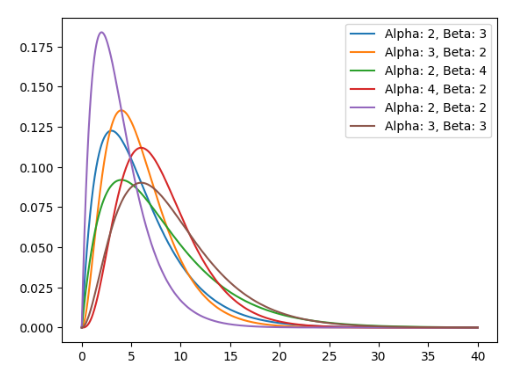

In [ ]:
# The distribution plots

# Set the variable to the path of the PNG file

dist_plot_1 = "../experiments/Experiment_2_new/1kt_c_lin_reg_2024-08-14-02-43-26/plots/distplots.png"

# Display the PNG file

img_dist_plot_1 = plt.imread(dist_plot_1)
plt.imshow(img_dist_plot_1)
plt.axis('off')
plt.show()


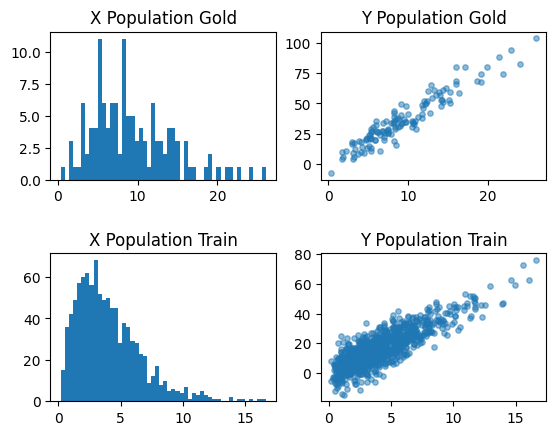

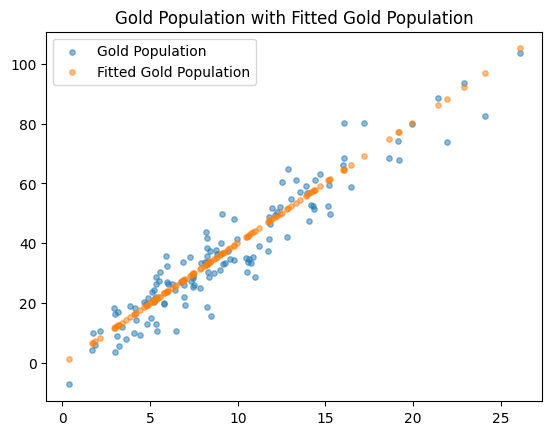

In [ ]:
# Visualize the two distributions

def test3(config):
    rho_vals = [.75]
    pop_config = config['experiment']['parameters']['gold_population']
    train_config = config['experiment']['parameters']['training_population']
    for rho in rho_vals:
        pop_config['y_population']['rho'] = rho
        train_config['y_population']['rho'] = rho

        pop_config['x_population']['alpha'] = 3
        pop_config['x_population']['beta'] = 3

        x_gold, y_gold = dist.sample_population(pop_config)

        ml_config = config['experiment']['model']

        x_train, y_train = dist.sample_population(train_config)

        model = ml.train_model(x_train, y_train, ml_config)

        y_gold_fitted = model.predict(x_gold)

        # plot the x population and the y population of both the gold and train populations
        fig, ax = plt.subplots(2, 2)
        ax[0, 0].hist(x_gold, bins=50)
        ax[0, 0].set_title("X Population Gold")
        ax[0, 1].scatter(x_gold, y_gold, alpha=0.5, s=15)
        ax[0, 1].set_title("Y Population Gold")
        ax[1, 0].hist(x_train, bins=50)
        ax[1, 0].set_title("X Population Train")
        ax[1, 1].scatter(x_train, y_train, alpha=0.5, s=15)
        ax[1, 1].set_title("Y Population Train")

        # put some vertical space between the plots
        plt.subplots_adjust(hspace=0.5)
        plt.show()

        # plot the gold population and the fitted gold population


        plt.scatter(x_gold, y_gold, alpha=0.5, s=15)
        plt.scatter(x_gold, y_gold_fitted, alpha=0.5, s=15)
        plt.legend(["Gold Population", "Fitted Gold Population"])
        plt.title("Gold Population with Fitted Gold Population")
        plt.show()
    

    return 

config4 = "../configs/Experiment_2_new/1kt_nc_lin_reg.yaml"

with open(config4, 'r') as stream:
    config4 = yaml.safe_load(stream)

test3(config4)

In this case, we have opted for a small training sample, where the size of the training data is only 1000. However, in this case the training data will see *most* of the inference data, in both the gold population and the unlabelled population. However, since the performance is very strong with the model, PPI will perform well on any distribution of $X^t$ so long as it has reasonable overlap with the distribution of $X^g$.

Since the model fits nearly perfectly, we expect performance to be the same, no matter what $X^g$ distribution, as there is considerable overlap between the training and inference population, the performance of PPI should not change much, since the model should perform around the same.

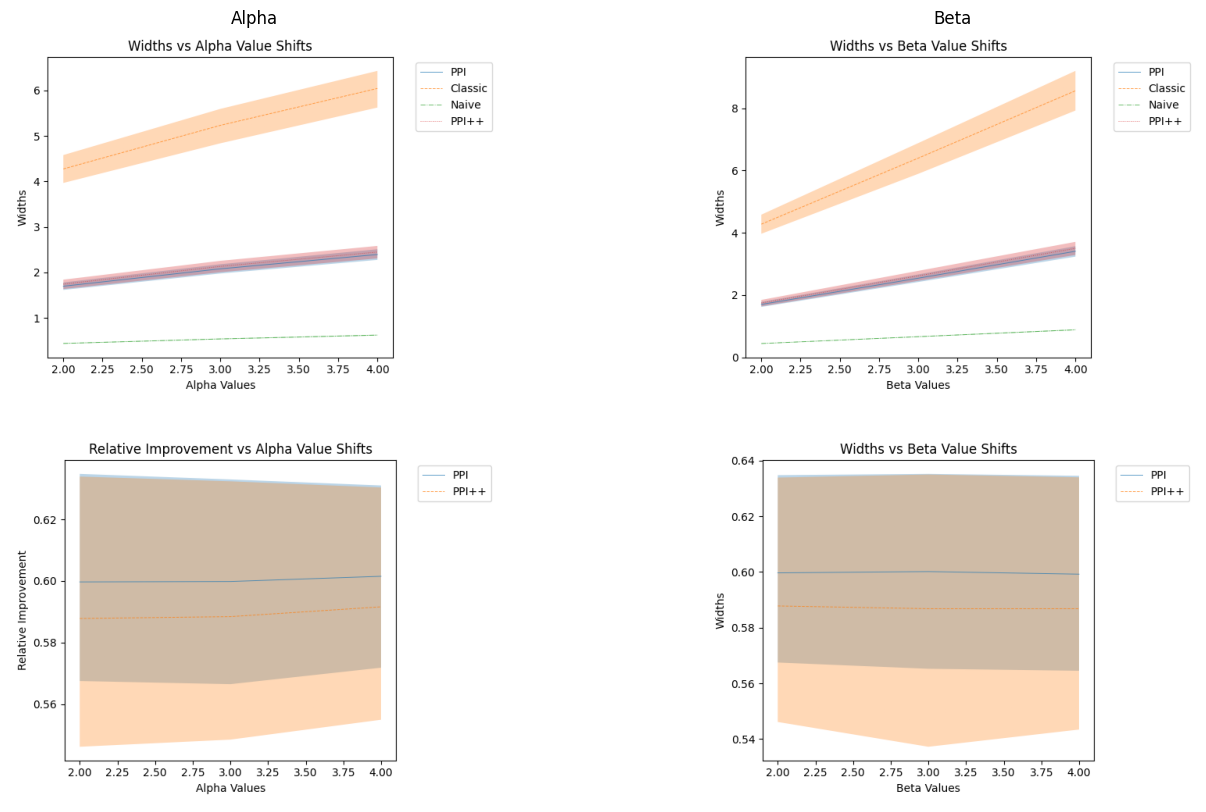

In [ ]:
# Display the widths plots

# Set the variable to the path of the PNG file
alpha_width = '../experiments/Experiment_2_new/1kt_nc_lin_reg_2024-08-14-02-46-41/plots/widths_alpha_shifts.png'
beta_width = '../experiments/Experiment_2_new/1kt_nc_lin_reg_2024-08-14-02-46-41/plots/widths_beta_shifts.png'
alpha_ri = '../experiments/Experiment_2_new/1kt_nc_lin_reg_2024-08-14-02-46-41/plots/relative_alpha_shifts.png'
beta_ri = '../experiments/Experiment_2_new/1kt_nc_lin_reg_2024-08-14-02-46-41/plots/relative_beta_shifts.png'

# Display the PNG file
img_alpha_width = plt.imread(alpha_width)
img_beta_width = plt.imread(beta_width)
img_alpha_ri = plt.imread(alpha_ri)
img_beta_ri = plt.imread(beta_ri)

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img_alpha_width)
ax[0, 0].axis('off')
ax[0, 0].set_title('Alpha')
ax[0, 1].imshow(img_beta_width)
ax[0, 1].axis('off')
ax[0, 1].set_title('Beta')
ax[1, 0].imshow(img_alpha_ri)
ax[1, 0].axis('off')
ax[1, 1].imshow(img_beta_ri)
ax[1, 1].axis('off')

# remove the whitespace between the plots
plt.subplots_adjust(wspace=0, hspace=0.1)

# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()


As expected, the relative improvement is constant, the only reason widths change at all is dependent on the variance of the distribution. For the sake of completion, let's take a look at the relative improvement with respect to Wasserstein Distance/Total Variation Distance from the initial distribution

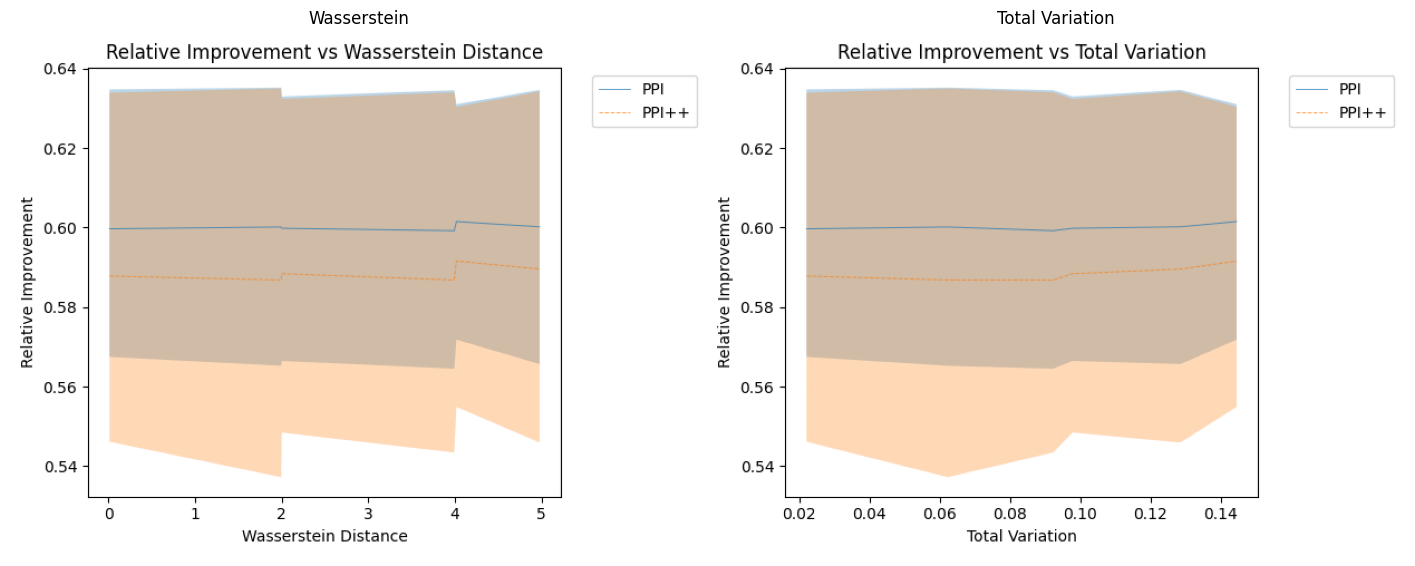

In [ ]:
# Display the widths plots

# Set the variable to the path of the PNG file
wass_ri = '../experiments/Experiment_2_new/1kt_nc_lin_reg_2024-08-14-02-46-41/plots/relative_improvement_wass.png'
tv_ri = '../experiments/Experiment_2_new/1kt_nc_lin_reg_2024-08-14-02-46-41/plots/relative_improvement_tv.png'

# Display the PNG file
img_wass_ri = plt.imread(wass_ri)
img_tv_ri = plt.imread(tv_ri)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_wass_ri)
ax[0].axis('off')
ax[0].set_title('Wasserstein')
ax[1].imshow(img_tv_ri)
ax[1].axis('off')
ax[1].set_title('Total Variation')


# remove the whitespace between the plots
plt.subplots_adjust(wspace=0, hspace=0.1)

# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()


A note on clipping: Since the performance is so good, clipping really doesn't make a difference.

### Setting 2

#### Non-linear data, difficult fit

In this setting, we will reuse the conditional distribution of $Y$ by setting $Y = 3 \sin(X) + \exp(X/6) + \varepsilon$. To illustrate the relationship this time, we will take a look at the conditional distribution of $Y$ for a large range.

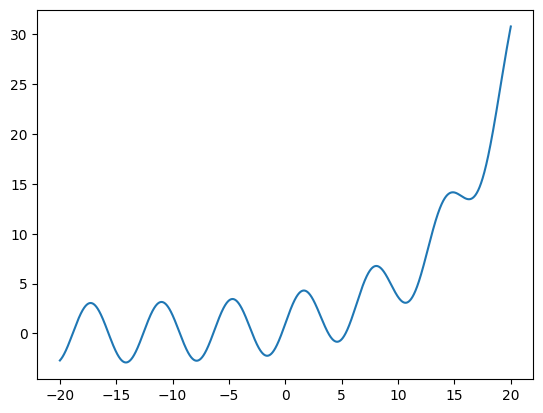

In [ ]:
# Perfect distribution plot

x = np.linspace(-20, 20, 10000)
y = 3 * np.sin(x) + np.exp(x/6)

plt.plot(x, y)
plt.show()

In this setting, we will also be taking the $X$ distribution to be variations of the normal distribution. We set the training distribution to be $X \sim N(0, 4)$. We will be varying the distributions of $X$ to be 

- $X_0 \sim N(0, 4)$

- $X_1 \sim N(2, 4)$

- $X_2 \sim N(-2, 4)$

- $X_3 \sim N(4, 4)$

- $X_4 \sim N(-4, 4)$

- $X_5 \sim N(0, 5)$

- $X_6 \sim N(0, 6)$

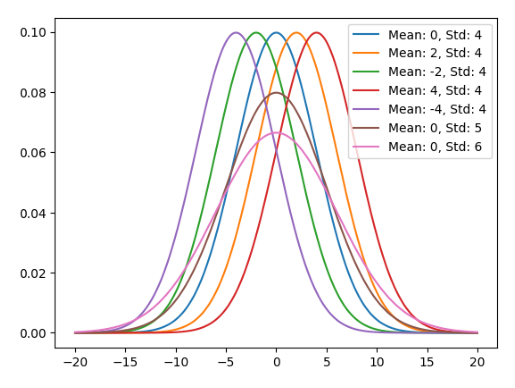

In [ ]:
# Display the distribution plots

dist_plot_2 = "../experiments/Experiment_2_new/1kt_nc_nonlin_reg_2024-08-14-04-06-06/plots/distplots.png"

# Display the PNG file

img_dist_plot_2 = plt.imread(dist_plot_2)
plt.imshow(img_dist_plot_2)
plt.axis('off')
plt.show()

Fitting becomes much harder therefore.

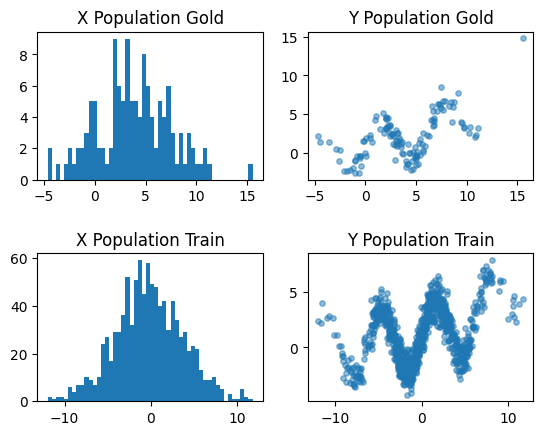

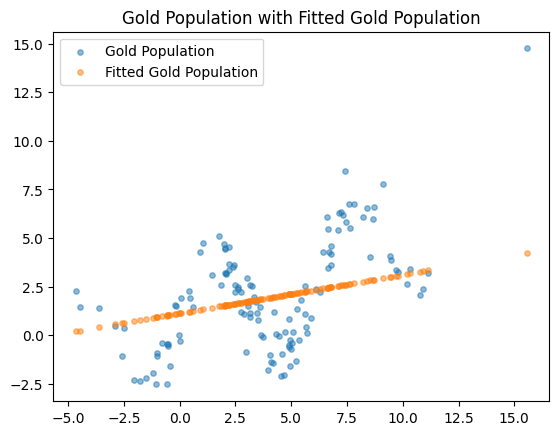

In [ ]:
# Visualize setting 2.2

config5 = "../configs/Experiment_2_new/1kt_nc_nonlin_reg.yaml"

with open(config5, 'r') as stream:
    config5 = yaml.safe_load(stream)

def test4(config):
    rho_vals = [.3]
    pop_config = config['experiment']['parameters']['gold_population']
    train_config = config['experiment']['parameters']['training_population']
    for rho in rho_vals:
        pop_config['y_population']['rho'] = rho
        train_config['y_population']['rho'] = rho

        pop_config['x_population']['mean'] = 4
        pop_config['x_population']['std'] = 4

        x_gold, y_gold = dist.sample_population(pop_config)

        ml_config = config['experiment']['model']

        x_train, y_train = dist.sample_population(train_config)

        model = ml.train_model(x_train, y_train, ml_config)

        y_gold_fitted = model.predict(x_gold)

        # plot the x population and the y population of both the gold and train populations
        fig, ax = plt.subplots(2, 2)
        ax[0, 0].hist(x_gold, bins=50)
        ax[0, 0].set_title("X Population Gold")
        ax[0, 1].scatter(x_gold, y_gold, alpha=0.5, s=15)
        ax[0, 1].set_title("Y Population Gold")
        ax[1, 0].hist(x_train, bins=50)
        ax[1, 0].set_title("X Population Train")
        ax[1, 1].scatter(x_train, y_train, alpha=0.5, s=15)
        ax[1, 1].set_title("Y Population Train")

        # put some vertical space between the plots
        plt.subplots_adjust(hspace=0.5)
        plt.show()

        # plot the gold population and the fitted gold population


        plt.scatter(x_gold, y_gold, alpha=0.5, s=15)
        plt.scatter(x_gold, y_gold_fitted, alpha=0.5, s=15)
        plt.legend(["Gold Population", "Fitted Gold Population"])
        plt.title("Gold Population with Fitted Gold Population")
        plt.show()
    

    return 

test4(config5)

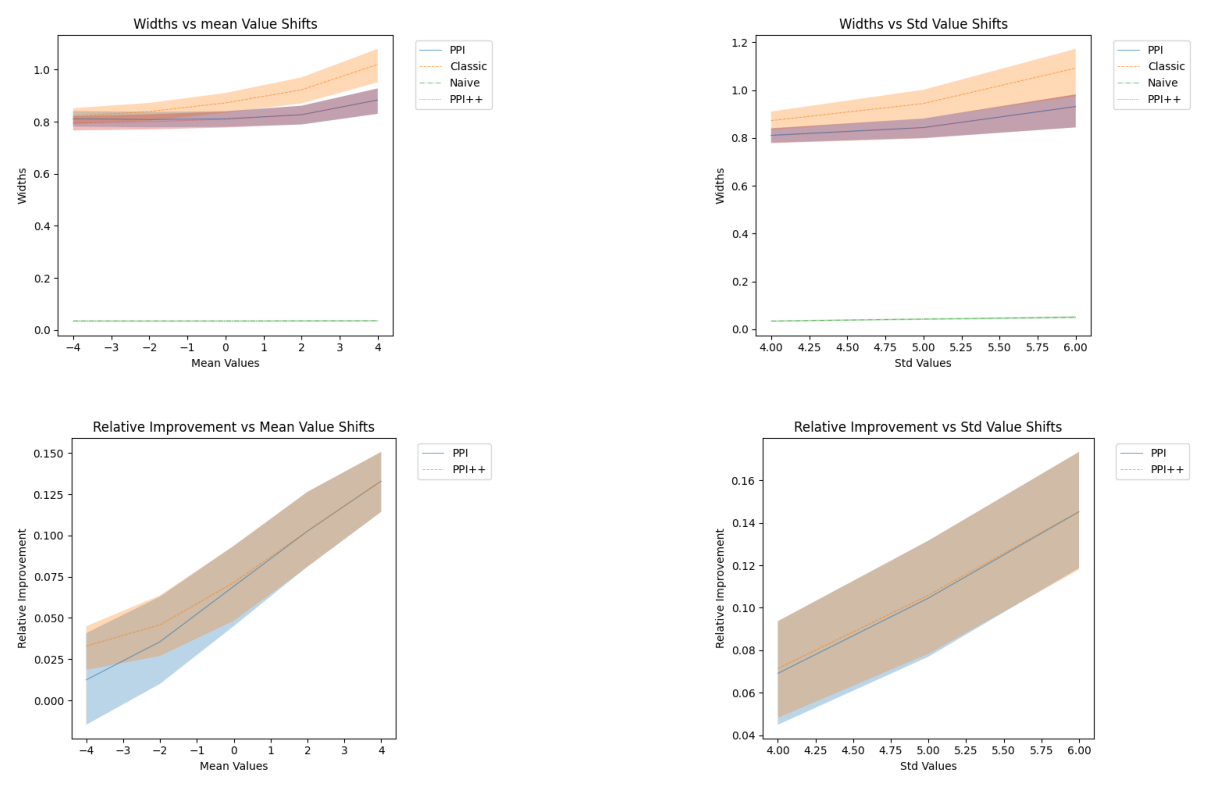

In [ ]:
# Display the wdiths vs rho plot

# Set the variable to the path of the PNG file
plot_1 = '../experiments/Experiment_2_new/1kt_nc_nonlin_reg_2024-08-17-15-41-28/plots/widths_mean_shifts.png'
plot_2 = '../experiments/Experiment_2_new/1kt_nc_nonlin_reg_2024-08-17-15-41-28/plots/widths_std_shifts.png'
plot_3 = '../experiments/Experiment_2_new/1kt_nc_nonlin_reg_2024-08-17-15-41-28/plots/relative_mean_shifts.png'
plot_4 = '../experiments/Experiment_2_new/1kt_nc_nonlin_reg_2024-08-17-15-41-28/plots/relative_std_shifts.png'

# Display the PNG file
img_plot_1 = plt.imread(plot_1)
img_plot_2 = plt.imread(plot_2)
img_plot_3 = plt.imread(plot_3)
img_plot_4 = plt.imread(plot_4)

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img_plot_1)
ax[0, 0].axis('off')
ax[0, 1].imshow(img_plot_2)
ax[0, 1].axis('off')
ax[1, 0].imshow(img_plot_3)
ax[1, 0].axis('off')
ax[1, 1].imshow(img_plot_4)
ax[1, 1].axis('off')

# remove the whitespace between the plots
plt.subplots_adjust(wspace=0, hspace=0.1)

# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()


 As expected, performance is on par, with the previous results. Albeit, one can see this is a scenario where PPI++ gives a significant bonus.

 Now let's move over to a more robust model, that can properly capture the pattern

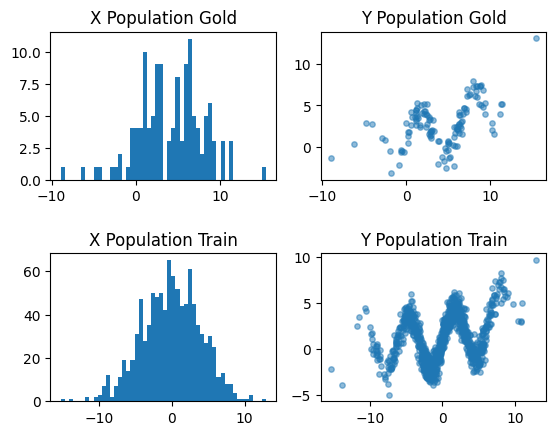

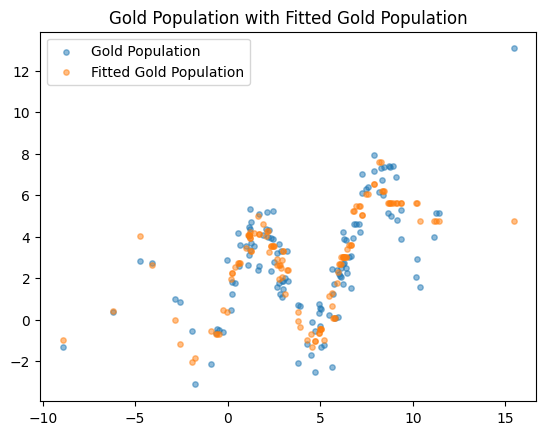

In [ ]:
# Visualize non-linear, xgb fitting

config6 = "../configs/Experiment_2_new/1kt_nc_nonlin_xgb.yaml"

with open(config6, 'r') as stream:
    config6 = yaml.safe_load(stream)

test4(config6)

Even with just 1000 training points, the fitting works pretty well.

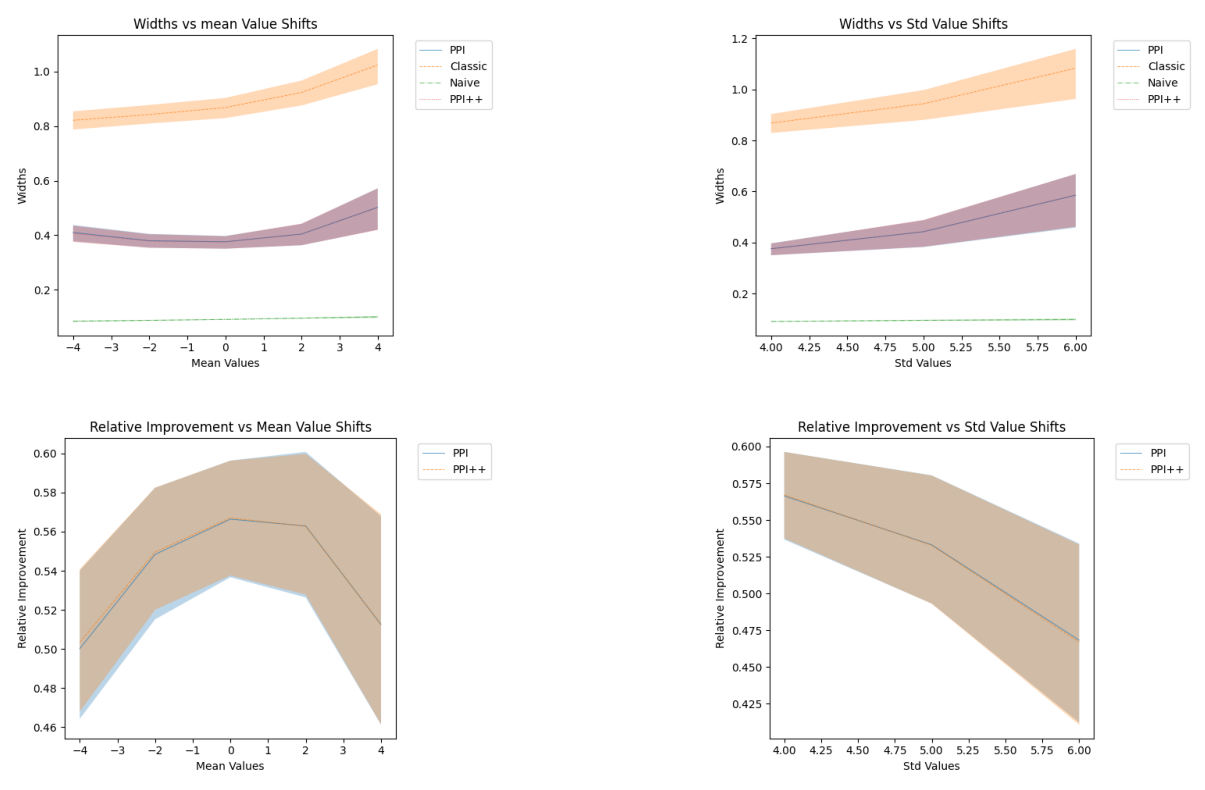

In [ ]:
# Display the wdiths vs rho plot

# Set the variable to the path of the PNG file
plot_1 = '../experiments/Experiment_2_new/1kt_nc_nonlin_xgb_2024-08-17-15-41-55/plots/widths_mean_shifts.png'
plot_2 = '../experiments/Experiment_2_new/1kt_nc_nonlin_xgb_2024-08-17-15-41-55/plots/widths_std_shifts.png'
plot_3 = '../experiments/Experiment_2_new/1kt_nc_nonlin_xgb_2024-08-17-15-41-55/plots/relative_mean_shifts.png'
plot_4 = '../experiments/Experiment_2_new/1kt_nc_nonlin_xgb_2024-08-17-15-41-55/plots/relative_std_shifts.png'

# Display the PNG file
img_plot_1 = plt.imread(plot_1)
img_plot_2 = plt.imread(plot_2)
img_plot_3 = plt.imread(plot_3)
img_plot_4 = plt.imread(plot_4)

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img_plot_1)
ax[0, 0].axis('off')
ax[0, 1].imshow(img_plot_2)
ax[0, 1].axis('off')
ax[1, 0].imshow(img_plot_3)
ax[1, 0].axis('off')
ax[1, 1].imshow(img_plot_4)
ax[1, 1].axis('off')

# remove the whitespace between the plots
plt.subplots_adjust(wspace=0, hspace=0.1)

# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()


There is small amounts of performance degredation as we move away from the training distribution, but overall, performance is good.

Let's increase the training size to 50000.

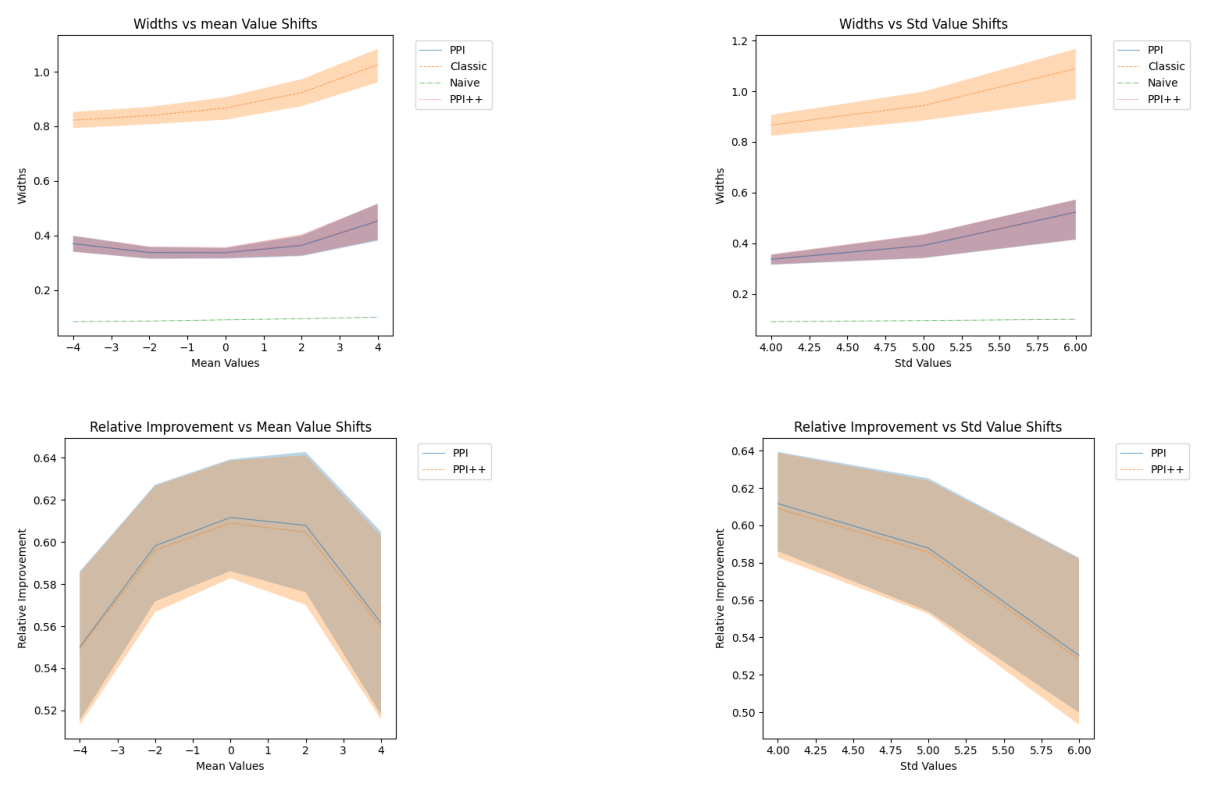

In [ ]:
# Display the wdiths vs rho plot

# Set the variable to the path of the PNG file
plot_1 = '../experiments/Experiment_2_new/50kt_c_nonlin_xgb_2024-08-17-03-58-43/plots/widths_mean_shifts.png'
plot_2 = '../experiments/Experiment_2_new/50kt_c_nonlin_xgb_2024-08-17-03-58-43/plots/widths_std_shifts.png'
plot_3 = '../experiments/Experiment_2_new/50kt_c_nonlin_xgb_2024-08-17-03-58-43/plots/relative_mean_shifts.png'
plot_4 = '../experiments/Experiment_2_new/50kt_c_nonlin_xgb_2024-08-17-03-58-43/plots/relative_std_shifts.png'

# Display the PNG file
img_plot_1 = plt.imread(plot_1)
img_plot_2 = plt.imread(plot_2)
img_plot_3 = plt.imread(plot_3)
img_plot_4 = plt.imread(plot_4)

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img_plot_1)
ax[0, 0].axis('off')
ax[0, 1].imshow(img_plot_2)
ax[0, 1].axis('off')
ax[1, 0].imshow(img_plot_3)
ax[1, 0].axis('off')
ax[1, 1].imshow(img_plot_4)
ax[1, 1].axis('off')

# remove the whitespace between the plots
plt.subplots_adjust(wspace=0, hspace=0.1)

# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()


With more training data of course, performance improves.

#### Clipping

One technique we can implement, is clipping, which is to say, we remove (unlabelled) data points that are outside of the data distribution, and do inference there. Let's see the results when the training data is set back to 1000 points.

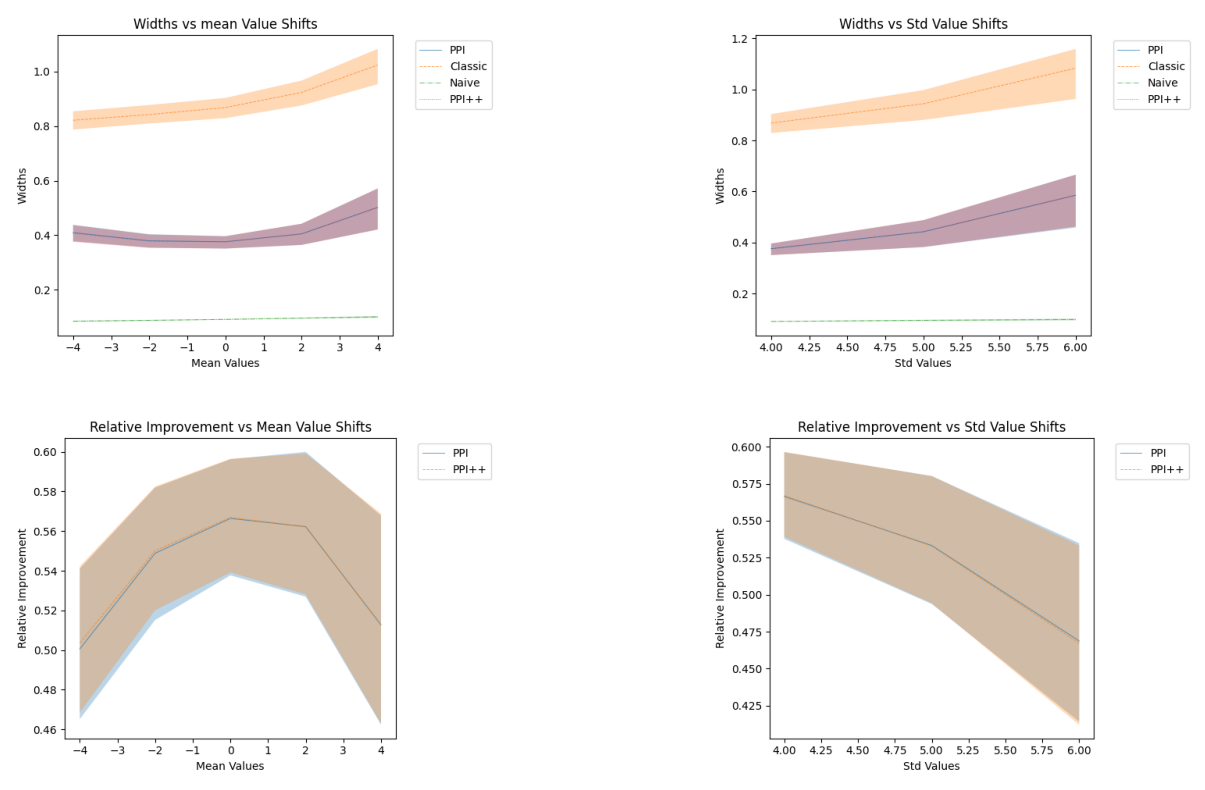

In [ ]:
# Display the wdiths vs rho plot

# Set the variable to the path of the PNG file
plot_1 = '../experiments/Experiment_2_new/1kt_c_nonlin_xgb_2024-08-17-15-10-54/plots/widths_mean_shifts.png'
plot_2 = '../experiments/Experiment_2_new/1kt_c_nonlin_xgb_2024-08-17-15-10-54/plots/widths_std_shifts.png'
plot_3 = '../experiments/Experiment_2_new/1kt_c_nonlin_xgb_2024-08-17-15-10-54/plots/relative_mean_shifts.png'
plot_4 = '../experiments/Experiment_2_new/1kt_c_nonlin_xgb_2024-08-17-15-10-54/plots/relative_std_shifts.png'

# Display the PNG file
img_plot_1 = plt.imread(plot_1)
img_plot_2 = plt.imread(plot_2)
img_plot_3 = plt.imread(plot_3)
img_plot_4 = plt.imread(plot_4)

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img_plot_1)
ax[0, 0].axis('off')
ax[0, 1].imshow(img_plot_2)
ax[0, 1].axis('off')
ax[1, 0].imshow(img_plot_3)
ax[1, 0].axis('off')
ax[1, 1].imshow(img_plot_4)
ax[1, 1].axis('off')

# remove the whitespace between the plots
plt.subplots_adjust(wspace=0, hspace=0.1)

# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()

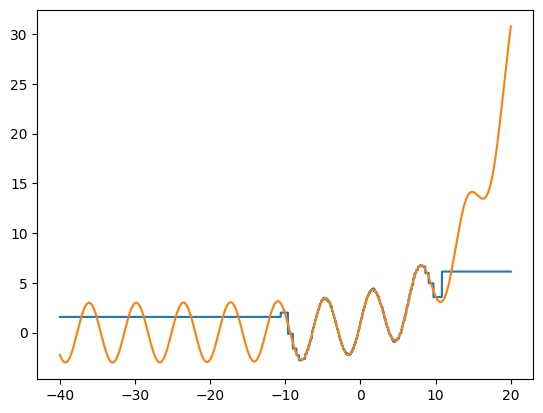

In [ ]:
# Visualize the fit of xgboost for a wide range of x values

config5 = "../configs/Experiment_2_new/50kt_nc_nonlin_xgb.yaml"

with open(config5, 'r') as stream:
    config5 = yaml.safe_load(stream)

train_config = config5['experiment']['parameters']['training_population']
train_x, train_y = dist.sample_population(train_config)

ml_config = config5['experiment']['model']

model = ml.train_model(train_x, train_y, ml_config)

x = np.linspace(-40, 20, 10000)

y_pred = model.predict(x)
y_true = 3 * np.sin(x) + np.exp(x/6)

plt.plot(x, y_pred)
plt.plot(x, y_true)
plt.show()

### Experiment 2 Summary

Here are the key insights gained from experiment 2:

- If the training distribution has a large amount of overlap with the labelled and unlabelled distribution, performance is more or less constant
- In a more complex setting, when there are ocassional out of training distribution points, performance starts degrading a little bit
- With more training data, performance improves, as it tends to see more out of distribuiton points
- Clipping when removing unlabelled data points, doesn't have much effect

## Experiment 3

In this experiment, we will redo much of the previous experiment, except this time, the distributions will be much further away so that the model does not know exactly how to predict out of distribution stuff.

The distributions look like the following, we will repeat the non-linear setting

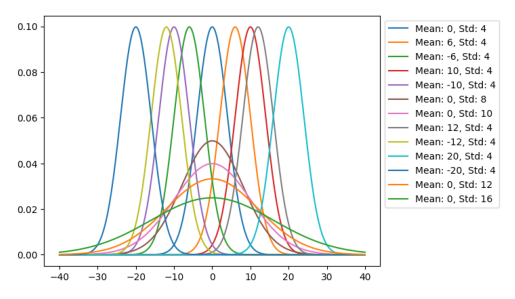

In [ ]:
# Display the distribution plots

dist_plot_2 = "../experiments/Experiment_3/exp_3_distplots.png"

# Display the PNG file

img_dist_plot_2 = plt.imread(dist_plot_2)
plt.imshow(img_dist_plot_2)
plt.axis('off')
plt.show()

50k training

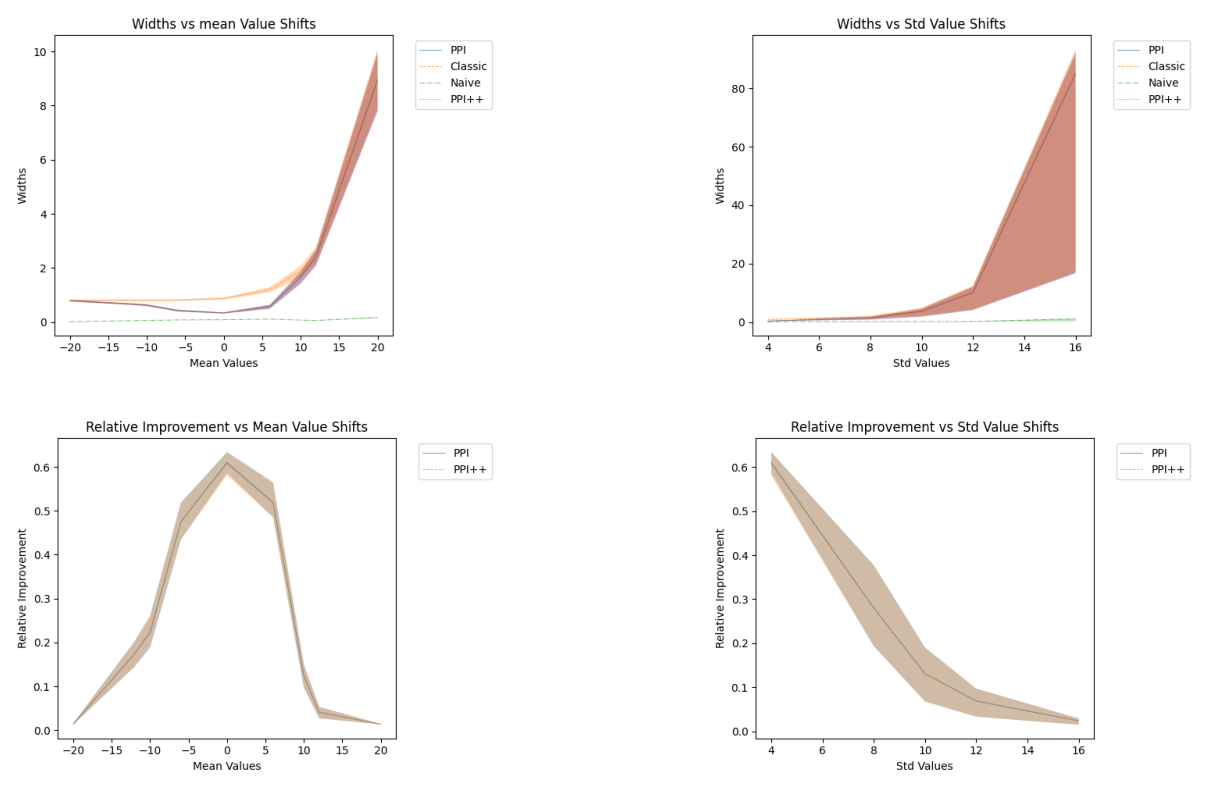

In [ ]:
# Display the wdiths vs rho plot

# Set the variable to the path of the PNG file
plot_1 = '../experiments/Experiment_3/10kt_nonlin_xgb_2024-08-20-03-26-15/plots/widths_mean_shifts.png'
plot_2 = '../experiments/Experiment_3/10kt_nonlin_xgb_2024-08-20-03-26-15/plots/widths_std_shifts.png'
plot_3 = '../experiments/Experiment_3/10kt_nonlin_xgb_2024-08-20-03-26-15/plots/relative_mean_shifts.png'
plot_4 = '../experiments/Experiment_3/10kt_nonlin_xgb_2024-08-20-03-26-15/plots/relative_std_shifts.png'

# Display the PNG file
img_plot_1 = plt.imread(plot_1)
img_plot_2 = plt.imread(plot_2)
img_plot_3 = plt.imread(plot_3)
img_plot_4 = plt.imread(plot_4)

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img_plot_1)
ax[0, 0].axis('off')
ax[0, 1].imshow(img_plot_2)
ax[0, 1].axis('off')
ax[1, 0].imshow(img_plot_3)
ax[1, 0].axis('off')
ax[1, 1].imshow(img_plot_4)
ax[1, 1].axis('off')

# remove the whitespace between the plots
plt.subplots_adjust(wspace=0, hspace=0.1)

# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()


In a terrible terrible example, suppose as well, that $n = N$. Then we have

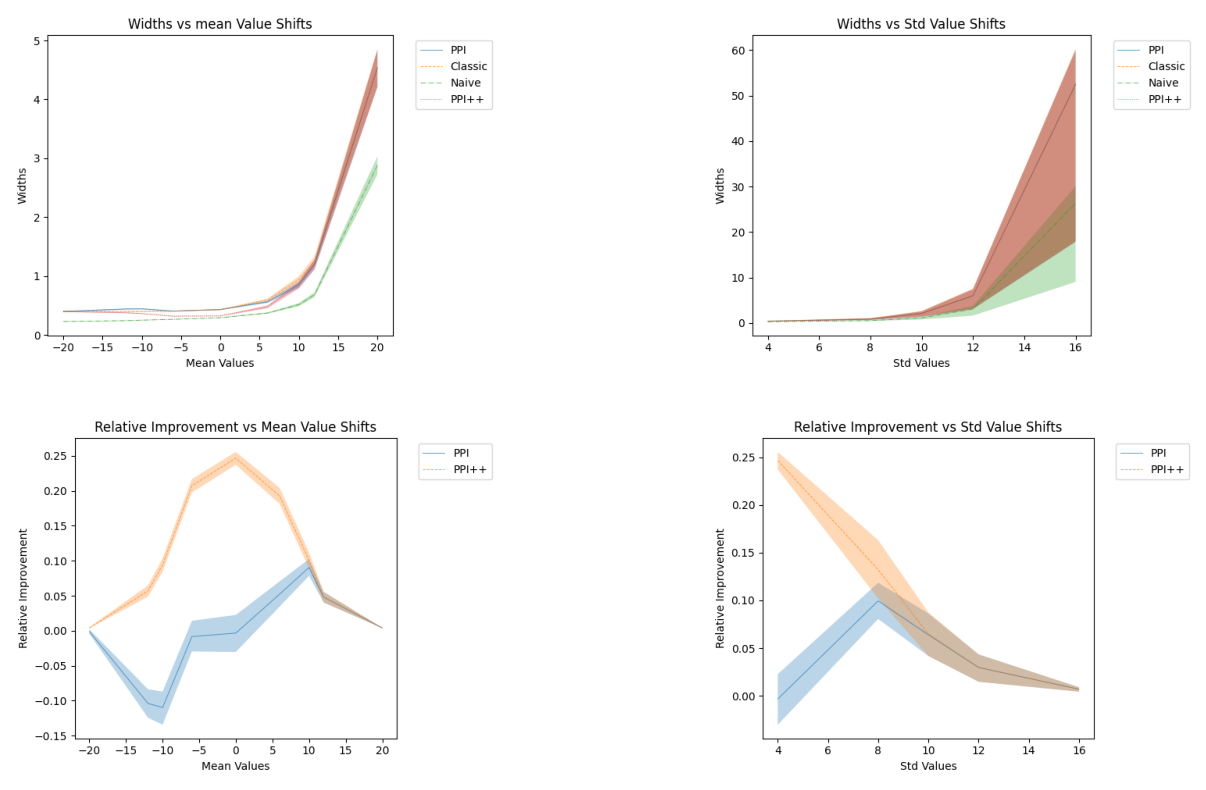

In [ ]:
# Display the wdiths vs rho plot

# Set the variable to the path of the PNG file
plot_1 = '../experiments/Experiment_3/50kt_nonlin_xgb_bad_ratio_2024-08-20-04-01-21/plots/widths_mean_shifts.png'
plot_2 = '../experiments/Experiment_3/50kt_nonlin_xgb_bad_ratio_2024-08-20-04-01-21/plots/widths_std_shifts.png'
plot_3 = '../experiments/Experiment_3/50kt_nonlin_xgb_bad_ratio_2024-08-20-04-01-21/plots/relative_mean_shifts.png'
plot_4 = '../experiments/Experiment_3/50kt_nonlin_xgb_bad_ratio_2024-08-20-04-01-21/plots/relative_std_shifts.png'

# Display the PNG file
img_plot_1 = plt.imread(plot_1)
img_plot_2 = plt.imread(plot_2)
img_plot_3 = plt.imread(plot_3)
img_plot_4 = plt.imread(plot_4)

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img_plot_1)
ax[0, 0].axis('off')
ax[0, 1].imshow(img_plot_2)
ax[0, 1].axis('off')
ax[1, 0].imshow(img_plot_3)
ax[1, 0].axis('off')
ax[1, 1].imshow(img_plot_4)
ax[1, 1].axis('off')

# remove the whitespace between the plots
plt.subplots_adjust(wspace=0, hspace=0.1)

# Enlarge the plot
fig.set_size_inches(18, 10)
plt.show()
